In [ ]:
import os
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

TARGET_COL = "import_value_eur_real_2025" 

In [8]:
# Load CSV for "non-predicted"-part
df = pl.read_csv("../data/Kaffee_Tee_Mate_und_Gewuerze_2007-2025_cleaned.csv", separator=",")
df.head(5)

import_value_eur,export_value_eur,import_qty_kg,export_qty_kg,date,export_value_eur_real_2025,import_value_eur_real_2025
i64,i64,i64,i64,str,f64,f64
27832809,16896986,9857615,4582769,"""2007-01-01""",2.7407e7,4.5145e7
24173222,13690849,9148603,3889454,"""2007-02-01""",2.2207e7,3.9209e7
27640476,19932106,10072434,5472440,"""2007-03-01""",3.2330e7,4.4833e7
25348582,16598993,9156889,4383299,"""2007-04-01""",2.6924e7,4.1115e7
28266053,16412072,10886785,4189638,"""2007-05-01""",2.6620e7,4.5848e7


In [9]:
# Load CSV for "predicted"-part
df_pred = pl.read_csv("../results/forecast_results_import_value_eur_future_only.csv", separator=",")
df_pred.head(5)

ds,yhat,y,split,model,family
str,f64,str,str,str,str
"""2025-10-01""",6.3790e7,null,"""future""","""arima""","""statistical"""
"""2025-11-01""",6.3790e7,null,"""future""","""arima""","""statistical"""
"""2025-12-01""",6.3790e7,null,"""future""","""arima""","""statistical"""
"""2026-01-01""",6.3790e7,null,"""future""","""arima""","""statistical"""
"""2026-02-01""",6.3790e7,null,"""future""","""arima""","""statistical"""


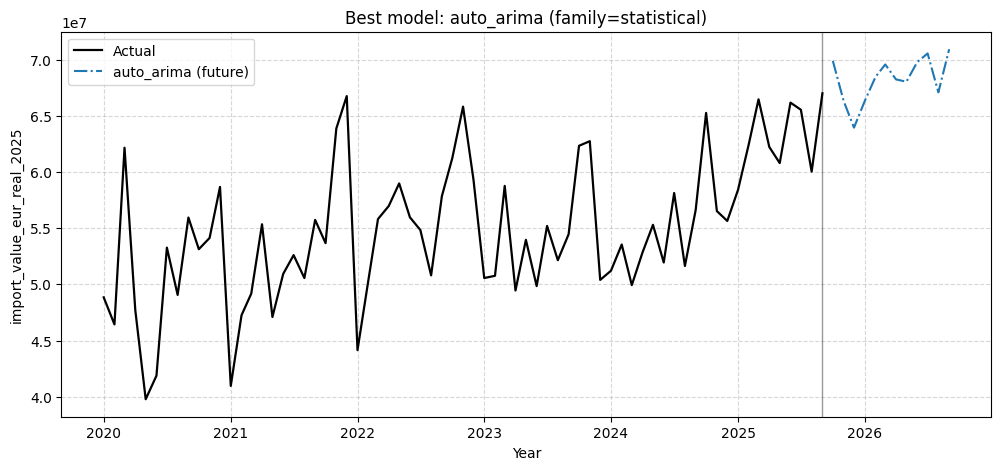

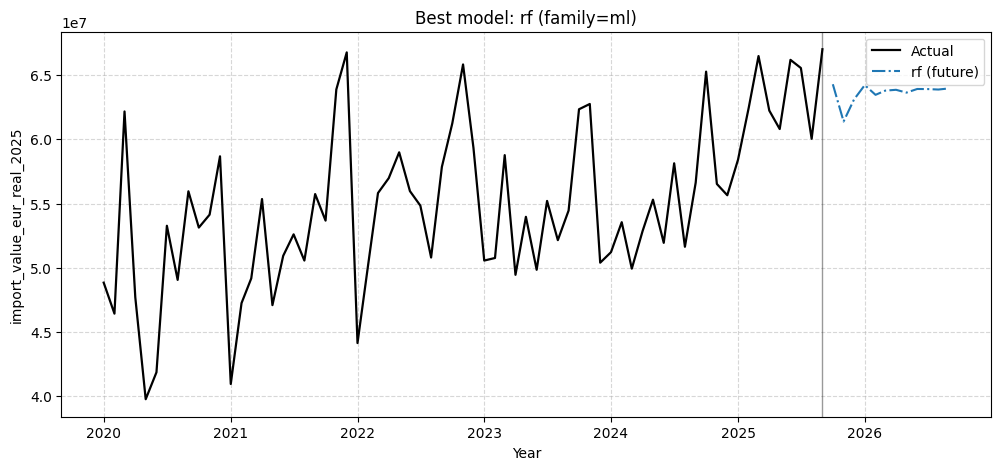

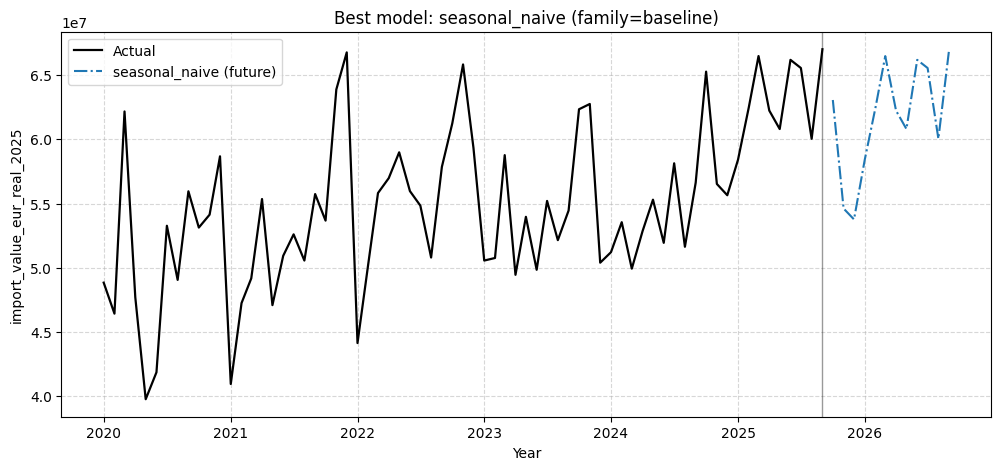

In [ ]:
# Manually selected models (by name) that have best stats overall
selected_models = [
    "auto_arima",
    "rf",
    "seasonal_naive",
]

forecasts_df = df_pred.to_pandas()
pdf_plot = df.to_pandas()
pdf_plot = pdf_plot[pdf_plot["date"] >= "2020-01-01"]

def plot_model_all_splits(
    forecasts_df: pd.DataFrame,
    pdf_plot: pd.DataFrame,
    model: str,
    *,
    value_col: str,
    date_col: str = "date",
 ):
    pdf_plot = pdf_plot.copy()
    pdf_plot[date_col] = pd.to_datetime(pdf_plot[date_col], errors="coerce")

    g = forecasts_df[forecasts_df["model"] == model].copy()
    g["ds"] = pd.to_datetime(g["ds"], errors="coerce")

    if g.empty:
        print(f"No forecasts found for model: {model}")
        return

    plt.figure(figsize=(12, 5))
    plt.plot(pdf_plot[date_col], pdf_plot[value_col], color="black", lw=1.6, label="Actual")

    for split, style in [("val", "--"), ("test", ":"), ("future", "-.")]:
        sg = g[g["split"] == split].sort_values("ds")
        if not sg.empty:
            plt.plot(sg["ds"], sg["yhat"], linestyle=style, label=f"{model} ({split})")

    plt.axvline(pdf_plot[date_col].max(), color="black", lw=1, alpha=0.4)

    start_year = pdf_plot[date_col].min().year
    end_year = max(pdf_plot[date_col].max().year, g["ds"].max().year)
    year_ticks = pd.date_range(f"{start_year}-01-01", f"{end_year}-01-01", freq="YS")
    plt.xticks(year_ticks, [str(y.year) for y in year_ticks])

    fam = g["family"].dropna().unique()
    fam_str = fam[0] if len(fam) else "unknown"
    plt.title(f"Best model: {model} (family={fam_str})")
    plt.xlabel("Year")
    plt.ylabel(value_col)
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.legend()
    plt.show()

for m in selected_models:
    plot_model_all_splits(forecasts_df, pdf_plot, m, value_col=TARGET_COL)